In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

443


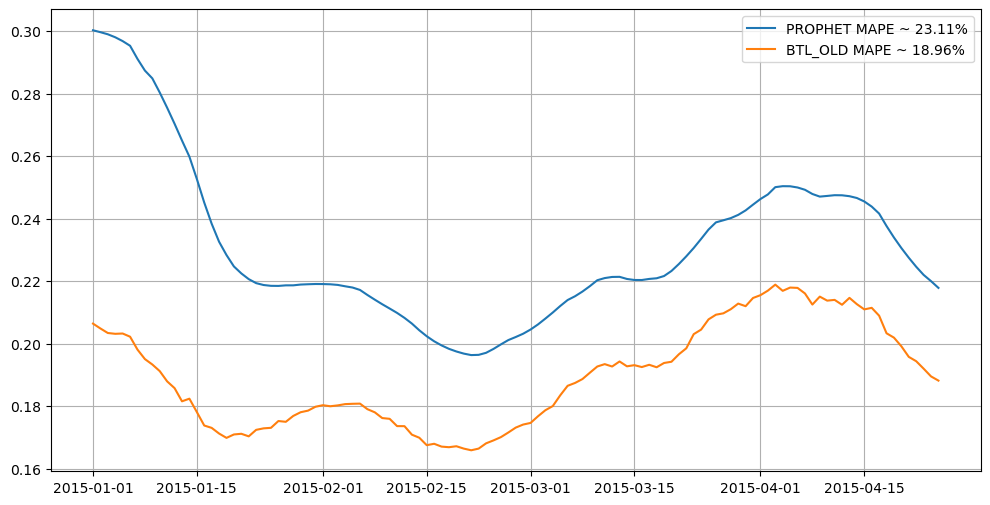

In [75]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
prophet_parent_path = Path("./") / "out" / "prophet"
vangja_parent_path = Path("./") / "out" / "vangja"

paths = [
    prophet_parent_path / "test2",
    vangja_parent_path / "test_ciit_3",
    # vangja_parent_path / "test_ciit_3",
    # vangja_parent_path / "test_ciit_2",
]
labels = [
    "PROPHET",
    "BTL_OLD",
    # "BTL",
    # "BTL + SCALING"
]
index = None

for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    model_name = f"prophet_{point_str}_multiplicative_lt0_w"
    csv_path = paths[0] / f"{model_name}.csv"
    vangja_path = paths[1] / f"{point_str}.csv"
    # vangja_path2 = paths[2] / f"{point_str}.csv"
    if not csv_path.is_file() or not vangja_path.is_file():
        continue

    index_1 = pd.read_csv(csv_path, index_col=0).index
    index_2 = pd.read_csv(vangja_path, index_col=0).index
    index_1 = index_1.intersection(index_2)
    if index is None:
        index = index_1

    index = index.intersection(index_1)

print(len(index))
plt.figure(figsize=(12, 6))

metrics_per_ticker = [{}, {}, {}, {}]
total_metrics = []

for idx, (path, label) in enumerate(zip(paths, labels)):
    dates = []
    mapes = []
    maes = []
    rmses = []
    mses = []
    for point in pd.date_range("2015-01-01", "2015-04-25"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = (
            path / f"prophet_{point_str}_multiplicative_lt0_w.csv"
            if idx == 0
            else path / f"{point_str}.csv"
        )

        if not csv_path.is_file():
            continue

        metrics = pd.read_csv(csv_path, index_col=0)
        for ticker in index:
            metrics_per_ticker[idx][ticker] = metrics_per_ticker[idx].get(
                ticker, {"mape": [], "mae": [], "rmse": [], "mse": []}
            )
            metrics_per_ticker[idx][ticker]["mape"].append(metrics.loc[ticker]["mape"])
            metrics_per_ticker[idx][ticker]["mae"].append(metrics.loc[ticker]["mae"])
            metrics_per_ticker[idx][ticker]["rmse"].append(metrics.loc[ticker]["rmse"])
            metrics_per_ticker[idx][ticker]["mse"].append(metrics.loc[ticker]["mse"])

        dates.append(point)
        mapes.append(metrics["mape"].mean())
        maes.append(metrics["mae"].mean())
        rmses.append(metrics["rmse"].mean())
        mses.append(metrics["mse"].mean())

    plt.plot(dates, mapes, label=f"{label} MAPE ~ {100 * sum(mapes) / len(mapes):.2f}%")
    total_metrics.append(
        {
            "mape": sum(mapes) / len(mapes),
            "mae": sum(maes) / len(maes),
            "rmse": sum(rmses) / len(rmses),
            "mse": sum(mses) / len(mses),
        }
    )

plt.grid()
plt.legend()

In [5]:
from vangja.data_utils import (
    download_data,
    generate_train_test_df_around_point,
    process_data,
)

dfs = download_data(Path("./data"))
indexes = process_data(dfs[0])
smp = [index for index in indexes if index["series"].iloc[0] == "^GSPC"]
gspc_tickers = process_data(dfs[1])

In [197]:
# GIS
best_score = 0
best_ticker = None
best_date = None
best_mapes = None

for ticker, prophet_metrics in metrics_per_ticker[0].items():
    # if ticker in ["DHR", "PRGO", "SLG", "WEC", "SO", "FCX", "MMC", "NTAP", "PSX"]:
    # if ticker in ["GIS"]:
    #     continue
    prophet_mapes = prophet_metrics["mape"]
    vangja_mapes = metrics_per_ticker[1][ticker]["mape"]
    for idx, (prophet_mape, vangja_mape) in enumerate(zip(prophet_mapes, vangja_mapes)):
        score = (prophet_mape - vangja_mape) / prophet_mape
        if score > best_score and vangja_mape < 0.02:
            best_score = score
            best_date = pd.to_datetime("2015-01-01") + pd.to_timedelta(f"{idx} days")
            best_ticker = ticker
            best_mapes = [prophet_mape, vangja_mape]


In [198]:
best_score, best_ticker, best_mapes, best_date

(0.7322211488570347,
 'GIS',
 [0.0668180817677888, 0.0178924691713552],
 Timestamp('2015-01-15 00:00:00'))

In [199]:
df = None
for ticker in gspc_tickers:
    if ticker["series"].iloc[0] == best_ticker:
        df = ticker

df

,typical_price,ds,series
0,NaN,1962-01-02,GIS
1,NaN,1962-01-03,GIS
2,NaN,1962-01-04,GIS
3,NaN,1962-01-05,GIS
4,NaN,1962-01-06,GIS
...,...,...,...
23005,63.182052,2024-12-27,GIS
23006,63.104489,2024-12-28,GIS
23007,63.026926,2024-12-29,GIS
23008,62.949362,2024-12-30,GIS


In [206]:
def plot(future, y_true, train):
    plt.figure(figsize=(12, 6))
    # plt.title("Forecasts")
    plt.grid()
    plt.plot(
        train["ds"],
        train["y"],
        lw=1,
        # s=0.5,
        # color="C0",
        label="Historical price",
    )
    plt.plot(y_true["ds"], y_true["y"], 
            #  s=0.5, 
            #  color="C1", 
            lw=1,
             label="Target")
    plt.plot(future["ds"], future["yhat"], lw=2, label=r"Forecast")
    plt.legend()

Output()

        mse      rmse      mae      mape
y  0.000625  0.025009  0.01877  0.017893


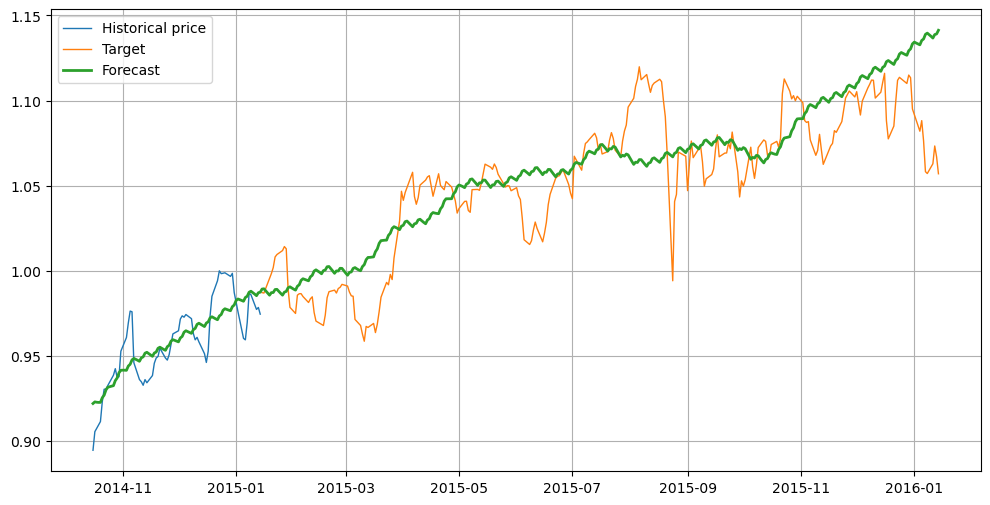

In [207]:
from vangja_simple.components import (
    BetaConstant,
    Constant,
    FourierSeasonality,
    LinearTrend,
)
from vangja_simple.components.normal_constant import NormalConstant

point = str(pd.to_datetime(best_date)).split(" ")[0]

train_df_smp, test_df_smp, scales_smp = generate_train_test_df_around_point(
    window=365 * 40, horizon=365, dfs=smp, for_prophet=False, point=point
)
train_df_tickers, test_df_tickers, scales_tickers = generate_train_test_df_around_point(
    window=91,
    horizon=365,
    dfs=[df],
    for_prophet=False,
    point=point,
)

trend = LinearTrend(changepoint_range=1)
yearly = FourierSeasonality(365.25, 10)
weekly = FourierSeasonality(7, 3)
model = trend ** (weekly + yearly)
model.fit(train_df_smp)
first_objs = model.save_model(prophet_parent_path, True)

trend = LinearTrend(n_changepoints=0)
yearly = FourierSeasonality(365.25, 10)
weekly = FourierSeasonality(7, 3)
model = trend ** (weekly + yearly)
model.load_model(prophet_parent_path, first_objs)
yearly.freeze()
map_approx = pd.read_csv(f"out/vangja/test_ciit_3/{point}_maps.csv", index_col=0)
row = map_approx.loc[train_df_tickers.iloc[0]["series"]]
for c in row.index:
    try:
        model.map_approx[c] = float(row[c])
    except:
        vals = [float(el) for el in str(row[c]).strip()[1:-1].split(" ") if el != ""]
        model.map_approx[c] = vals


model.tune(train_df_tickers, progressbar=False)
yhat = model.predict(365)
plot(yhat.iloc[-len(train_df_tickers)-len(test_df_tickers):], test_df_tickers, train_df_tickers)
print(model.metrics(test_df_tickers, yhat))

21:53:06 - cmdstanpy - INFO - Chain [1] start processing


21:53:06 - cmdstanpy - INFO - Chain [1] done processing


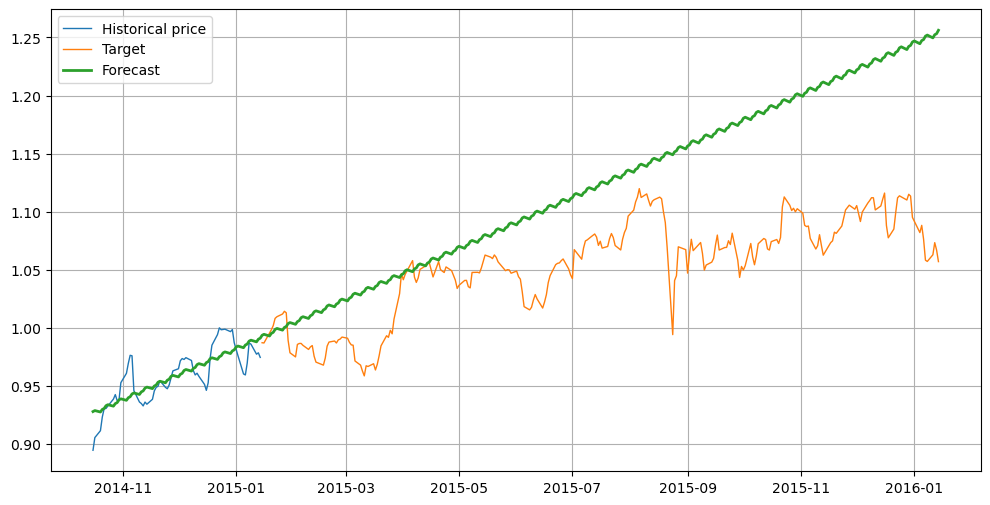

In [208]:
from prophet import Prophet

pr = Prophet(seasonality_mode="multiplicative", n_changepoints=0)
pr.fit(train_df_tickers)
future = pr.predict(pr.make_future_dataframe(365))
plot(future, test_df_tickers, train_df_tickers)

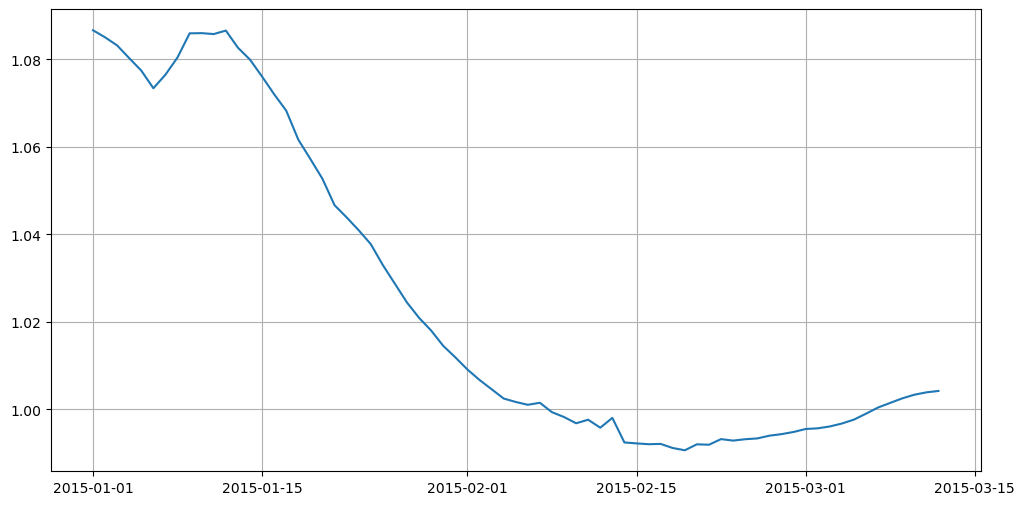

In [32]:
maps_path = Path("./") / "out" / "vangja" / "test_ciit_2"
map_approx = []
means = []
stds = []
dates = []
for point in pd.date_range("2015-01-01", "2017-01-01"):
    point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
    csv_path = maps_path / f"{point_str}_maps.csv"
    if not csv_path.is_file():
        continue

    map_approx.append(pd.read_csv(csv_path, index_col=0))
    dates.append(point)
    means.append(map_approx[-1][["nc_0 - normal(mu=1,sd=0.1)"]].mean())
    stds.append(map_approx[-1][["nc_0 - normal(mu=1,sd=0.1)"]].std())


plt.figure(figsize=(12, 6))
plt.plot(dates, means)
plt.grid()

<Axes: >

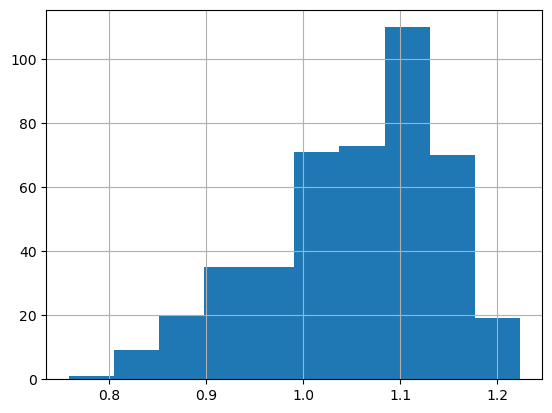

In [28]:
final_map_approx = map_approx[0].copy()
for ma in map_approx[1:]:
    final_map_approx += ma

(final_map_approx["nc_0 - normal(mu=1,sd=0.1)"] / len(map_approx)).hist()

In [30]:
(final_map_approx["nc_0 - normal(mu=1,sd=0.1)"] / len(map_approx)).sort_values()

PM      0.758780
HAS     0.815346
HRL     0.827938
DVA     0.828936
GOOG    0.832526
          ...   
ATO     1.211404
CINF    1.213080
ED      1.213161
AEP     1.213784
EIX     1.223269
Name: nc_0 - normal(mu=1,sd=0.1), Length: 443, dtype: float64

In [22]:
map_approx[0]

,"nc_0 - normal(mu=1,sd=0.1)",sigma_log__,sigma,lt_0 - slope,lt_0 - intercept,"fs_0 - beta(p=7,n=3)","fs_1 - beta(p=365.25,n=10)"
A,274.635703,-973.215942,8.141513,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
AAL,293.021677,-578.994501,34.432321,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
AAP,314.912550,-859.877705,12.260000,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
AAPL,300.289786,-924.545266,9.775339,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
ABBV,306.264913,-862.681395,12.514024,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
...,...,...,...,...,...,...,...
YUM,291.566798,-975.113438,8.091740,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
ZBH,315.092964,-936.310725,9.294381,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
ZBRA,314.004794,-807.352402,15.178247,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...
ZION,258.189214,-890.323312,11.039428,-716.378604,974.902757,[ 0.00183613 0.00122372 0.0002253 -0.000637...,[ 1.24830528e-02 -5.31203288e-03 -1.92488003e-...


In [10]:
map_approx[0][["nc_0 - normal(mu=1,sd=0.1)"]].mean(), map_approx[0][["nc_0 - normal(mu=1,sd=0.1)"]].std()

(nc_0 - normal(mu=1,sd=0.1)    1.086657
 dtype: float64,
 nc_0 - normal(mu=1,sd=0.1)    0.170154
 dtype: float64)

<Axes: >

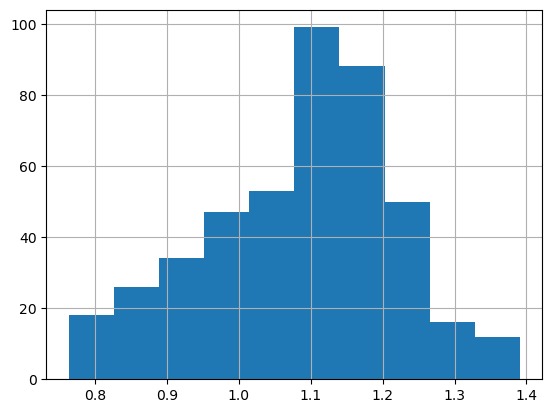

In [8]:
map_approx[10]["nc_0 - normal(mu=1,sd=0.1)"].hist()

In [36]:
pd.DataFrame.from_dict(metrics_per_ticker[0])
prophet_metrics = {
    ticker: {
        metric: sum(scores) / len(scores)
        for metric, scores in metrics_per_ticker[0][ticker].items()
    }
    for ticker in metrics_per_ticker[0].keys()
}
vangja_metrics = {
    ticker: {
        metric: sum(scores) / len(scores)
        for metric, scores in metrics_per_ticker[1][ticker].items()
    }
    for ticker in metrics_per_ticker[1].keys()
}
vangja_metrics_2 = {
    ticker: {
        metric: sum(scores) / len(scores)
        for metric, scores in metrics_per_ticker[2][ticker].items()
    }
    for ticker in metrics_per_ticker[2].keys()
}
prophet_metrics = pd.DataFrame(prophet_metrics)
vangja_metrics = pd.DataFrame(vangja_metrics)
vangja_metrics_2 = pd.DataFrame(vangja_metrics_2)
# metrics_per_ticker[0]

In [40]:
((prophet_metrics - vangja_metrics) / prophet_metrics).sort_values("mape", axis=1)

,NVR,GPN,SBUX,DVA,T,ULTA,META,VRSK,CPB,UAA,...,PWR,NEM,EA,APA,ALK,OKE,URI,HAL,FTI,FCX
mape,-0.361496,-0.301938,-0.249049,-0.167951,-0.163144,-0.161355,-0.139297,-0.137308,-0.132621,-0.131051,...,0.460468,0.474255,0.475248,0.480849,0.501887,0.612114,0.622955,0.656074,0.704259,0.800152
mae,-0.381959,-0.306115,-0.272242,-0.165308,-0.161981,-0.172570,-0.143379,-0.153456,-0.145043,-0.144081,...,0.453672,0.469690,0.486026,0.474831,0.521075,0.605401,0.612329,0.642007,0.696470,0.786673
rmse,-0.399723,-0.269039,-0.229075,-0.124998,-0.162530,-0.119935,-0.163511,-0.120836,-0.173470,-0.122240,...,0.440083,0.459598,0.447760,0.456505,0.486501,0.585980,0.596750,0.631337,0.688841,0.772234
mse,-0.858542,-0.614026,-0.476276,-0.307374,-0.419576,-0.296242,-0.224191,-0.174014,-0.146985,-0.240666,...,0.693964,0.730084,0.688327,0.647011,0.731281,0.845859,0.844776,0.873281,0.906248,0.945527


In [44]:
top_k_vangja = ((prophet_metrics - vangja_metrics) / prophet_metrics).sort_values("mape", axis=1).columns[-10:]
top_k_vangja2 = ((prophet_metrics - vangja_metrics_2) / prophet_metrics).sort_values("mape", axis=1).columns[-10:]
top_k_vangja, top_k_vangja2

(Index(['PWR', 'NEM', 'EA', 'APA', 'ALK', 'OKE', 'URI', 'HAL', 'FTI', 'FCX'], dtype='object'),
 Index(['NEM', 'ARE', 'ANET', 'KMX', 'WHR', 'GLW', 'BXP', 'VNO', 'UAL', 'RMD'], dtype='object'))

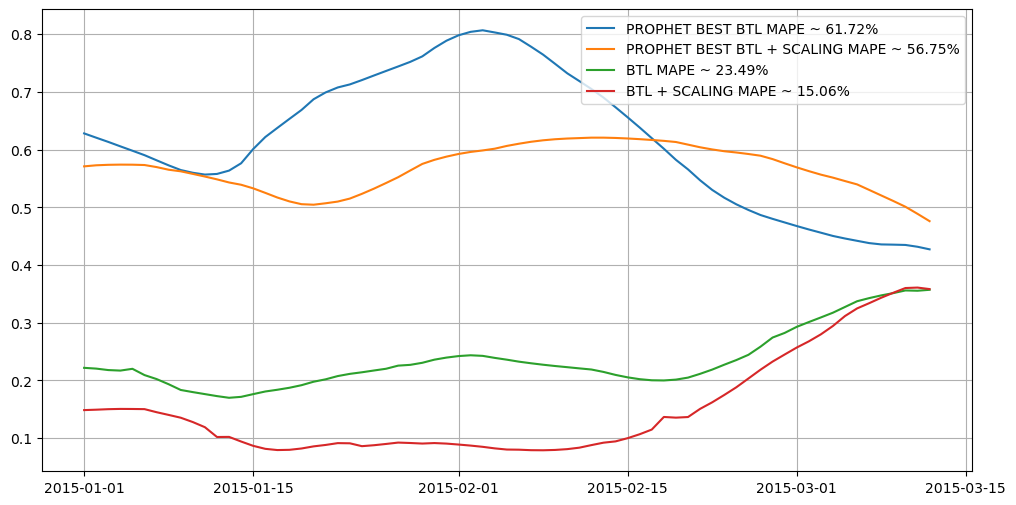

In [49]:
# test10 - NC * yT + wF
# test11 - BC * yT + wT
prophet_parent_path = Path("./") / "out" / "prophet"
vangja_parent_path = Path("./") / "out" / "vangja"

paths = [
    prophet_parent_path / "test2",
    prophet_parent_path / "test2",
    vangja_parent_path / "test_ciit_3",
    vangja_parent_path / "test_ciit_2",
]
labels = [
    "PROPHET BEST BTL",
    "PROPHET BEST BTL + SCALING",
    "BTL",
    "BTL + SCALING"
]
best = [top_k_vangja, top_k_vangja2, top_k_vangja, top_k_vangja2]
index = None

plt.figure(figsize=(12, 6))

metrics_per_ticker = [{}, {}, {}]
total_metrics = []

for idx, (path, label, best_index)  in enumerate(zip(paths, labels, best)):
    dates = []
    mapes = []
    for point in pd.date_range("2015-01-01", "2015-03-12"):
        point_str = f"{point.year}-{'' if point.month > 9 else '0'}{point.month}-{'' if point.day > 9 else '0'}{point.day}"
        csv_path = (
            path / f"prophet_{point_str}_multiplicative_lt0_w.csv"
            if idx < 2
            else path / f"{point_str}.csv"
        )

        if not csv_path.is_file():
            continue

        metrics = pd.read_csv(csv_path, index_col=0).loc[best_index]
        dates.append(point)
        mapes.append(metrics["mape"].mean())

    plt.plot(dates, mapes, label=f"{label} MAPE ~ {100 * sum(mapes) / len(mapes):.2f}%")
    

plt.grid()
plt.legend()

In [48]:
metrics, mapes

(          mse      rmse       mae      mape
 PWR  0.122389  0.349841  0.280066  0.393716
 NEM  0.887621  0.942136  0.839878  1.150259
 EA   0.220911  0.470011  0.382384  0.336655
 APA  0.253354  0.503343  0.441199  0.680302
 ALK  0.048566  0.220377  0.181705  0.175234
 OKE  0.052765  0.229706  0.187062  0.327341
 URI  0.014676  0.121143  0.100507  0.139400
 HAL  0.188302  0.433938  0.355877  0.441266
 FTI  0.069748  0.264098  0.245034  0.372385
 FCX  0.016336  0.127812  0.110171  0.255309,
 [])

In [39]:
((prophet_metrics - vangja_metrics_2) / prophet_metrics).sort_values("mape", axis=1)

,ULTA,CNP,NVR,SBUX,GRMN,MKTX,NRG,NI,JNPR,EFX,...,NEM,ARE,ANET,KMX,WHR,GLW,BXP,VNO,UAL,RMD
mape,-2.955253,-1.893209,-1.843539,-1.801543,-1.509023,-1.355000,-1.347719,-1.206266,-1.193146,-1.164958,...,0.718367,0.723108,0.725408,0.729607,0.729892,0.734261,0.742658,0.745032,0.749697,0.749998
mae,-3.045869,-1.911506,-1.878475,-1.865581,-1.514447,-1.449116,-1.133137,-1.311137,-1.292991,-1.273968,...,0.717318,0.723561,0.731347,0.728022,0.733213,0.734117,0.741166,0.745035,0.757366,0.735299
rmse,-2.578553,-1.417657,-1.694985,-1.649327,-1.360496,-1.221272,-1.193733,-1.262537,-0.993449,-0.971400,...,0.709148,0.724504,0.721555,0.722381,0.732772,0.737659,0.742464,0.741575,0.758721,0.735502
mse,-13.730080,-6.328004,-6.734008,-6.014431,-2.819803,-3.673386,-2.857758,-4.912335,-3.383455,-2.513514,...,0.912853,0.904281,0.924453,0.914003,0.901251,0.904451,0.909231,0.906891,0.926760,0.920807


In [37]:
res = ((prophet_metrics - vangja_metrics_2) / prophet_metrics).sort_values("mape", axis=1)[
    ["NVDA", "ORLY", "PGR", "EXPD", "URI", "HES", "WYNN", "FCX"][::-1]
]

for col in res.columns:
    print("\hline")
    line = f"\\textit{{{col}}}& "
    for metric in ["mse", "rmse", "mae", "mape"]:
        line += f"{res[col].loc[metric] * 100:.2f}\%" 
        if metric != "mape":
            line += " & "
    
    print(line + " \\\\")
    if col == "EXPD":
        print("\\multicolumn{5}{|c|}{...}\\\\")

\hline
\textit{FCX}& 5.48\% & -1.74\% & -3.17\% & -6.56\% \\
\hline
\textit{WYNN}& -149.74\% & -63.86\% & -72.35\% & -69.77\% \\
\hline
\textit{HES}& 23.92\% & 15.54\% & 17.51\% & 14.22\% \\
\hline
\textit{URI}& 47.04\% & 24.50\% & 23.26\% & 21.04\% \\
\hline
\textit{EXPD}& -4.77\% & -8.74\% & -13.52\% & -13.59\% \\
\multicolumn{5}{|c|}{...}\\
\hline
\textit{PGR}& -121.67\% & -42.93\% & -46.32\% & -46.47\% \\
\hline
\textit{ORLY}& -189.23\% & -98.17\% & -113.29\% & -112.76\% \\
\hline
\textit{NVDA}& -76.26\% & -31.67\% & -31.60\% & -25.87\% \\


<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1536957/3824959536.py:6: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")
/tmp/ipykernel_1536957/3824959536.py:9: SyntaxWarning: invalid escape sequence '\%'
  line += f"{res[col].loc[metric] * 100:.2f}\%"


In [62]:
prophet_metrics.loc["mape"].mean()

0.24069160646613982

In [40]:
prophet_metrics["mape"]

KeyError: 'mape'

In [22]:
prophet_metrics = pd.DataFrame(metrics_per_ticker[0])
vangja_metrics = pd.DataFrame(metrics_per_ticker[1])
((prophet_metrics - vangja_metrics) / prophet_metrics).loc["mape"].mean()

prophet_metrics.loc["mape"].mean(), vangja_metrics.loc["mape"].mean()

(0.27774740731230624, 0.21381126246740323)

In [23]:
prophet_metrics

,DGX,IFF,MMC,LKQ,BMY,EFX,FTI,D,WAB,NKE,...,T,HD,JNPR,MSFT,REG,CTSH,STX,DXC,BKNG,KIM
mape,0.141394,0.443628,0.019547,0.138080,0.334689,0.382960,0.607577,0.067032,0.192403,0.090742,...,0.250422,0.035068,0.459064,0.049016,0.272872,0.105369,0.275467,0.062038,0.100174,0.141579
mae,0.150731,0.447037,0.021868,0.140945,0.332994,0.365965,0.472933,0.070135,0.167461,0.100078,...,0.229027,0.040766,0.446211,0.055216,0.239339,0.123477,0.262727,0.080710,0.118433,0.100696
rmse,0.215857,0.508602,0.027048,0.188187,0.357913,0.393511,0.527887,0.081031,0.200558,0.119001,...,0.272838,0.051925,0.512715,0.063087,0.273575,0.138566,0.315188,0.092692,0.135699,0.127094
mse,0.046594,0.258676,0.000732,0.035414,0.128101,0.154851,0.278665,0.006566,0.040223,0.014161,...,0.074440,0.002696,0.262877,0.003980,0.074843,0.019201,0.099344,0.008592,0.018414,0.016153


In [10]:
x = pd.DataFrame.from_records(total_metrics)
x

,mape,mae,rmse,mse
0,0.242117,0.233501,0.269581,0.114700
1,0.191730,0.187777,0.218383,0.069757


In [12]:
(x.iloc[0] - x.iloc[1]) / x.iloc[0]

mape    0.208109
mae     0.195821
rmse    0.189915
mse     0.391833
dtype: float64

In [4]:
ti = pd.DataFrame(metrics_per_ticker[0]).mean().sort_values().index
best = (
    (
        pd.DataFrame(metrics_per_ticker[0]).mean().loc[ti]
        - pd.DataFrame(metrics_per_ticker[1]).mean().loc[ti]
    )
    / pd.DataFrame(metrics_per_ticker[0]).mean().loc[ti]
).sort_values(ascending=False)
best

FCX     0.549111
WYNN    0.440643
HES     0.412938
URI     0.401821
ILMN    0.373837
          ...   
CBOE    0.005110
EXPD    0.004497
PGR    -0.001364
ORLY   -0.003523
NVDA   -0.144390
Length: 443, dtype: float64

In [5]:
metrics

,mse,rmse,mae,mape
A,0.171393,0.413997,0.372548,0.284736
AAL,0.234867,0.484631,0.436322,0.450822
AAP,0.330592,0.574971,0.494549,0.849119
AAPL,0.173417,0.416434,0.384924,0.287698
ABBV,0.133659,0.365594,0.282395,0.208538
...,...,...,...,...
YUM,0.042941,0.207222,0.176796,0.149983
ZBH,0.128986,0.359147,0.334469,0.370038
ZBRA,0.017998,0.134156,0.101215,0.085715
ZION,0.140412,0.374715,0.326920,0.319030
